# OpenCV vs Deeplearning

In [ ]:
#import libraries
import os
import numpy as np
import pandas as pd
import json
from zipfile import ZipFile
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2 as cv
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.callbacks import EarlyStopping, ModelCheckpoint,LearningRateScheduler,ReduceLROnPlateau
from keras.layers import Activation, MaxPool2D, Concatenate
from tensorflow.keras.optimizers import Adam
from skimage.filters import threshold_otsu
from tensorflow.keras.utils import normalize

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Road detection using OpenCV Canny edge filter technique






### 1.1 Examples working well using canny edge filter



In [ ]:
def opencv_working():
  
  arr_sat = ['train/100034_sat.jpg','train/100081_sat.jpg','train/105596_sat.jpg','train/106523_sat.jpg']
  arr_mask = ['train/100034_mask.png','train/100081_mask.png','train/105596_mask.png','train/106523_mask.png']

  for i in range(len(arr_sat)):

    #read normal satellite image
    img_sat = cv.imread(arr_sat[i])
    img_sat = cv.cvtColor(img_sat, cv.COLOR_BGR2RGB)
    
    #read mask image
    img_mask = cv.imread(arr_mask[i])
    
    #compute canny edges using satellite image
    gray_img = cv.cvtColor(img_sat, cv.COLOR_BGR2GRAY)
    blur_img = cv.GaussianBlur(gray_img, (3,3), 0)
    img_canny = cv.Canny(image=blur_img, threshold1=130, threshold2=255)

    #plot the satellite,mask and canny edge image
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 3, 1)
    plt.title(arr_sat[i].split('/')[1])
    plt.imshow(img_sat)

    plt.subplot(1, 3, 2)
    plt.title(arr_mask[i].split('/')[1])
    plt.imshow(img_mask[:,:,0],cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title('prediction image')
    plt.imshow(img_canny,cmap='gray')

    plt.show()

  return None

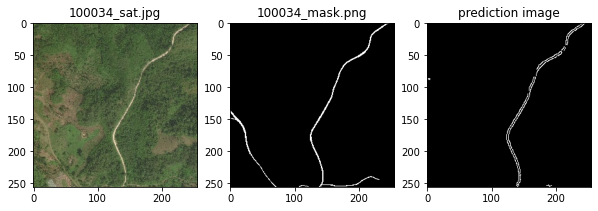

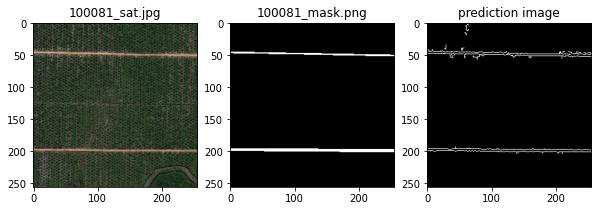

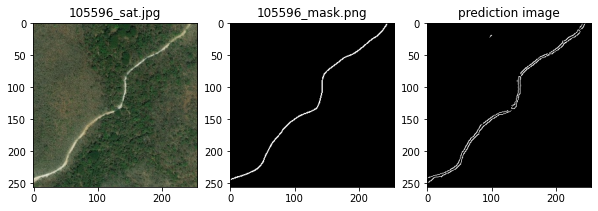

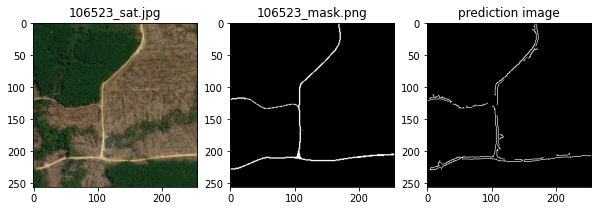

In [ ]:
opencv_working()

### 1.2 Examples failing using canny edge filter

In [ ]:
def opencv_notworking():
  
  arr_sat = ['train/107770_sat.jpg','train/106797_sat.jpg','train/10466_sat.jpg','train/111121_sat.jpg']
  arr_mask = ['train/107770_mask.png','train/106797_mask.png','train/10466_mask.png','train/111121_mask.png']

  for i in range(len(arr_sat)):

    #read normal satellite image
    img_sat = cv.imread(arr_sat[i])
    img_sat = cv.cvtColor(img_sat, cv.COLOR_BGR2RGB)
    
    #read mask image
    img_mask = cv.imread(arr_mask[i])
    
    #compute canny edges using satellite image
    gray_img = cv.cvtColor(img_sat, cv.COLOR_BGR2GRAY)
    blur_img = cv.GaussianBlur(gray_img, (3,3), 0)
    img_canny = cv.Canny(image=blur_img, threshold1=150, threshold2=255)

    #plot the satellite,mask and canny edge image
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 3, 1)
    plt.title(arr_sat[i].split('/')[1])
    plt.imshow(img_sat)

    plt.subplot(1, 3, 2)
    plt.title(arr_mask[i].split('/')[1])
    plt.imshow(img_mask[:,:,0],cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title('prediction image')
    plt.imshow(img_canny,cmap='gray')

    plt.show()

  return None

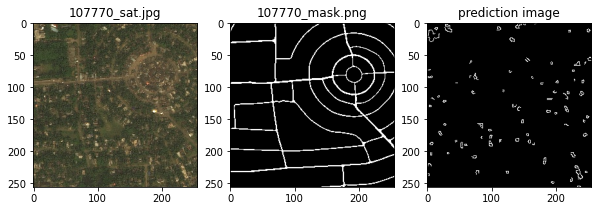

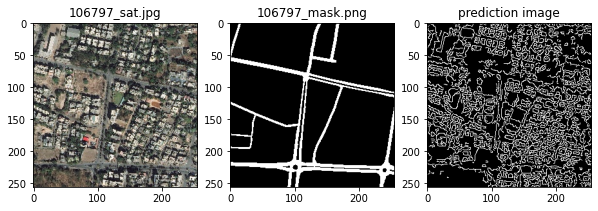

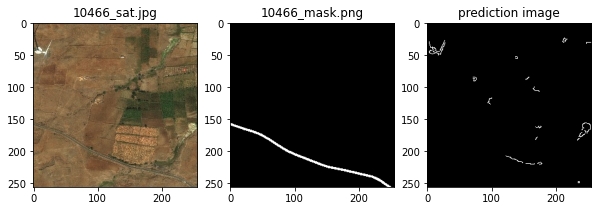

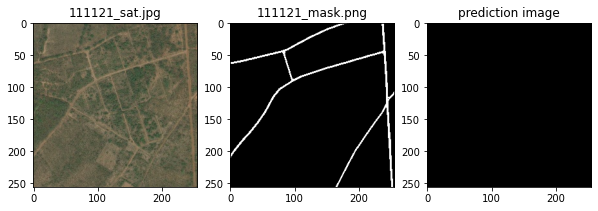

In [ ]:
opencv_notworking()

## 2. Deep learning Modelling with custom created Unet architecture

### 2.1 Reading the preprocessed image datasets

In [ ]:
#Extract all the resized archived files

ra = ZipFile("/content/drive/MyDrive/Colab_Notebooks/DeepGlobeRoadExtraction/ResizeArchive.zip","r")
ra.extractall()

In [ ]:
#Read the metadata file which contains paths of normal satellite images and mask paths

df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/DeepGlobeRoadExtraction/metadata.csv')
df.head()

image_id  split        sat_image_path              mask_path
0    100034  train  train/100034_sat.jpg  train/100034_mask.png
1    100081  train  train/100081_sat.jpg  train/100081_mask.png
2    100129  train  train/100129_sat.jpg  train/100129_mask.png
3    100703  train  train/100703_sat.jpg  train/100703_mask.png
4    100712  train  train/100712_sat.jpg  train/100712_mask.png

In [ ]:
#valid dataset doesn't contain the mask images so we shall use fraction of train dataset for valid purpose

#prepare the valid and train index for splitting the dataframe into train and valid datasets
train_data = df[df['split'] == 'train']
valid_index = train_data.sample(frac=0.20,random_state=42).index.to_list()
train_index = [each for each in train_data.index.to_list() if each not in valid_index]

#create the train and valid dataframes 
train_df = train_data.filter(items=train_index, axis=0)
valid_df = train_data.filter(items=valid_index, axis=0)

In [ ]:
#print the number of data points both in train and valid datasets

print('Number of data points in train_df - '+str(train_df.shape[0]))
print('Number of data points in valid_df - '+str(valid_df.shape[0]))

Number of data points in train_df - 4981
Number of data points in valid_df - 1245


### 2.2 Create a custom U-Net architecture

In [ ]:
#reference - https://github.com/bnsreenu/python_for_microscopists/blob/master/219-unet_model_with_functions_of_blocks.py

def conv_block(input, num_filters):

    x = Conv2D(num_filters, 3, padding="same", kernel_initializer='he_normal')(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same", kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)  

    model = Model(inputs, outputs, name="U-Net")
    return model


In [ ]:
#created a model that takes input shape as (256,256,3)

model = build_unet((256,256,3))

In [ ]:
#printing model summary

model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

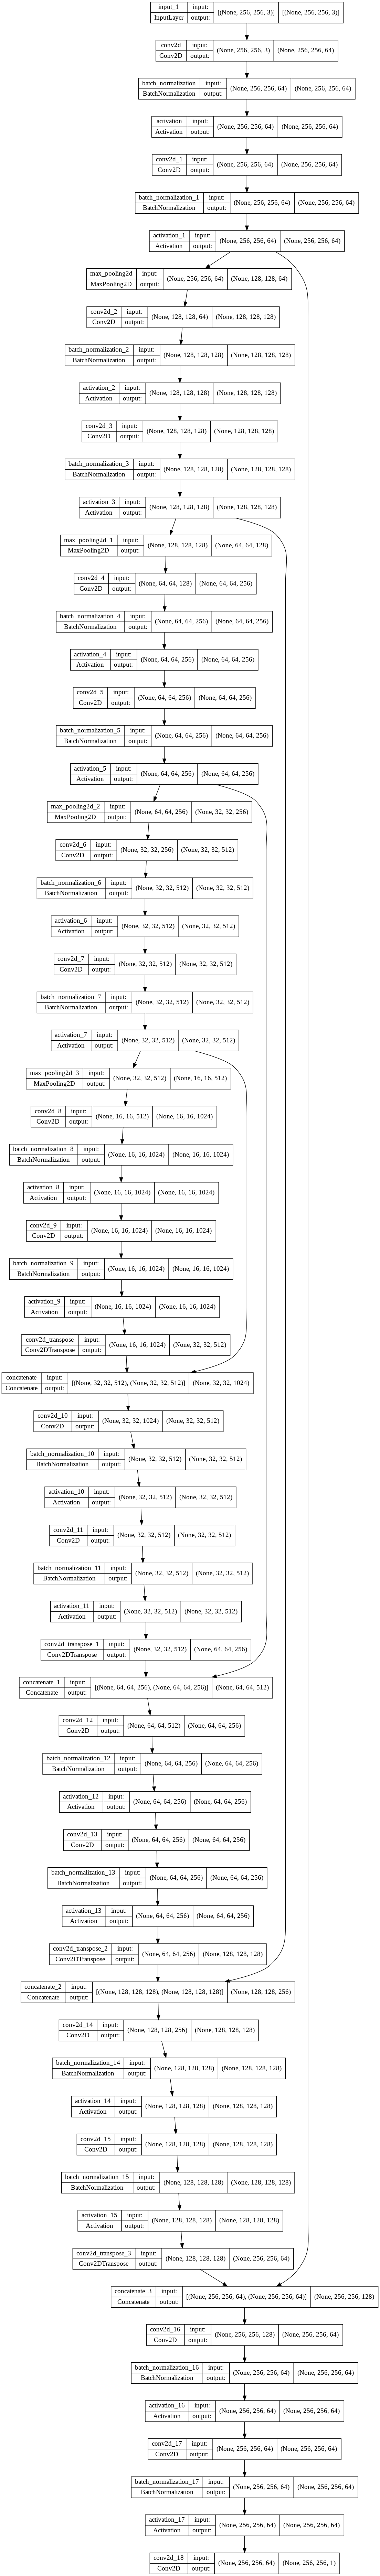

In [ ]:
#plotting the unet model architecture

tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### 2.3 U-Net Model training process

In [ ]:
import imgaug.augmenters as iaa

aug1 = iaa.Fliplr(1)
aug2 = iaa.Flipud(1)

In [ ]:
class Dataset:
    def __init__(self, df, Augment=False):
        
        self.df = df
        self.Augment = Augment
        self.sat_images_path_list = self.df['sat_image_path'].to_list() 
        self.mask_images_path_list = self.df['mask_path'].to_list() 
    
    def __getitem__(self, i):
        
        # read image directly into RGB format
        image = plt.imread(self.sat_images_path_list[i])

        # read image mask
        image_mask  = plt.imread(self.mask_images_path_list[i])
        image_mask = image_mask[:,:,0]

        if self.Augment == True:
          x = np.random.uniform()
          if x<0.3:
            image = aug1.augment_image(image)
            image_mask = aug1.augment_image(image_mask)
          elif x<0.6:
            image = aug2.augment_image(image)
            image_mask = aug2.augment_image(image_mask)
          else:
            pass
        
        return image, image_mask
    
    def __len__(self):
        return len(self.df)

In [ ]:
class DataLoader(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [ ]:
def custom_iou(y_true,y_pred):
  y_pred_logical = y_pred>=0.5
  y_true_logical = y_true.astype('bool')
  intersection_area = np.sum(np.logical_and(y_true_logical,y_pred_logical))
  union_area = np.sum(np.logical_or(y_true_logical,y_pred_logical))
  iou_score = round(intersection_area/union_area,3)
  return iou_score

In [ ]:
def iou(y_true,y_pred):
  return tf.numpy_function(custom_iou, (y_true, y_pred), tf.double)

### 2.3.1 No Augmentation

In [ ]:
train_dataset = Dataset(train_df, Augment=False)
valid_dataset = Dataset(valid_df, Augment=False)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=True)

print(train_dataloader[0][0].shape)
print(valid_dataloader[0][1].shape)

model.compile(optimizer = Adam(0.001), loss='binary_crossentropy', metrics=[iou])            

(32, 256, 256, 3)
(32, 256, 256)


In [ ]:
# define callbacks for learning rate scheduling and best checkpoints saving
filepath = '/content/drive/MyDrive/Colab_Notebooks/DeepGlobeRoadExtraction/weights/U_Net_no_augment/weights-{epoch:02d}-{val_iou:.3f}.h5'

callbacks = [ModelCheckpoint(filepath=filepath, save_weights_only=True, save_best_only=True,mode='max', monitor='val_iou',verbose=1),
             EarlyStopping(monitor='val_iou',min_delta=0.001,patience=5,mode='max',verbose=1)]

In [ ]:
history = model.fit(x=train_dataloader,steps_per_epoch=len(train_dataloader),epochs=25,validation_data=valid_dataloader,callbacks=callbacks)

Epoch 1/25
155/155 [==============================] - ETA: 0s - loss: 0.1790 - iou: 0.0036
Epoch 1: val_iou improved from -inf to 0.00000, saving model to /content/drive/MyDrive/Colab_Notebooks/DeepGlobeRoadExtraction/weights/U_Net_no_augment/weights-01-0.000.h5
155/155 [==============================] - 314s 2s/step - loss: 0.1790 - iou: 0.0036 - val_loss: 0.4524 - val_iou: 0.0000e+00
Epoch 2/25
155/155 [==============================] - ETA: 0s - loss: 0.1239 - iou: 0.1152
Epoch 2: val_iou improved from 0.00000 to 0.08439, saving model to /content/drive/MyDrive/Colab_Notebooks/DeepGlobeRoadExtraction/weights/U_Net_no_augment/weights-02-0.084.h5
155/155 [==============================] - 290s 2s/step - loss: 0.1239 - iou: 0.1152 - val_loss: 0.1285 - val_iou: 0.0844
Epoch 3/25
155/155 [==============================] - ETA: 0s - loss: 0.1012 - iou: 0.2753
Epoch 3: val_iou improved from 0.08439 to 0.34513, saving model to /content/drive/MyDrive/Colab_Notebooks/DeepGlobeRoadExtraction/we

In [ ]:
model.load_weights('/content/drive/MyDrive/Colab_Notebooks/DeepGlobeRoadExtraction/weights/U_Net_no_augment/weights-06-0.449.h5')

In [ ]:
history = model.fit(x=train_dataloader,steps_per_epoch=len(train_dataloader),epochs=15,validation_data=valid_dataloader,callbacks=callbacks)

Epoch 1/15
155/155 [==============================] - ETA: 0s - loss: 0.0748 - iou: 0.4441
Epoch 1: val_iou improved from -inf to 0.47221, saving model to /content/drive/MyDrive/Colab_Notebooks/DeepGlobeRoadExtraction/weights/U_Net_no_augment/weights-01-0.472.h5
155/155 [==============================] - 299s 2s/step - loss: 0.0748 - iou: 0.4441 - val_loss: 0.0816 - val_iou: 0.4722
Epoch 2/15
155/155 [==============================] - ETA: 0s - loss: 0.0712 - iou: 0.4648
Epoch 2: val_iou did not improve from 0.47221
155/155 [==============================] - 294s 2s/step - loss: 0.0712 - iou: 0.4648 - val_loss: 0.0820 - val_iou: 0.3736
Epoch 3/15
155/155 [==============================] - ETA: 0s - loss: 0.0682 - iou: 0.4830
Epoch 3: val_iou did not improve from 0.47221
155/155 [==============================] - 295s 2s/step - loss: 0.0682 - iou: 0.4830 - val_loss: 0.0725 - val_iou: 0.4589
Epoch 4/15
155/155 [==============================] - ETA: 0s - loss: 0.0653 - iou: 0.5006
Epoch 

In [ ]:
history = model.fit(x=train_dataloader,steps_per_epoch=len(train_dataloader),epochs=10,validation_data=valid_dataloader,callbacks=callbacks)

Epoch 1/10
155/155 [==============================] - ETA: 0s - loss: 0.0424 - iou: 0.6475
Epoch 1: val_iou did not improve from 0.54761
155/155 [==============================] - 284s 2s/step - loss: 0.0424 - iou: 0.6475 - val_loss: 0.0679 - val_iou: 0.5308
Epoch 2/10
155/155 [==============================] - ETA: 0s - loss: 0.0405 - iou: 0.6603
Epoch 2: val_iou improved from 0.54761 to 0.56108, saving model to /content/drive/MyDrive/Colab_Notebooks/DeepGlobeRoadExtraction/weights/U_Net_no_augment/weights-02-0.561.h5
155/155 [==============================] - 294s 2s/step - loss: 0.0405 - iou: 0.6603 - val_loss: 0.0645 - val_iou: 0.5611
Epoch 3/10
155/155 [==============================] - ETA: 0s - loss: 0.0394 - iou: 0.6678
Epoch 3: val_iou did not improve from 0.56108
155/155 [==============================] - 294s 2s/step - loss: 0.0394 - iou: 0.6678 - val_loss: 0.0728 - val_iou: 0.5404
Epoch 4/10
155/155 [==============================] - ETA: 0s - loss: 0.0375 - iou: 0.6809
Epo

In [ ]:
model.load_weights('/content/drive/MyDrive/Colab_Notebooks/DeepGlobeRoadExtraction/weights/U_Net_no_augment/weights-09-0.576.h5')

In [20]:
iou_no_augment = [0.0036,0.1152,0.2753,0.3571,0.3981,0.4256,0.4441,0.4648,0.4830,0.5006,0.5127,0.5256,0.5417,0.5510,0.5609,0.5700,0.5859,0.5928,0.6083,0.6174,0.6350,0.6475,0.6603,0.6678,0.6809,0.6932,0.7078,0.7110,0.7283,0.7364]
val_iou_no_augment = [0,0.0844,0.3451,0.3485,0.3317,0.4485,0.4722,0.3736,0.4589,0.4552,0.4193,0.4999,0.4859,0.5127,0.5157,0.5271,0.5242,0.5103,0.4751,0.5106,0.5476,0.5308,0.5611,0.5404,0.5568,0.5556,0.5623,0.5539,0.5576,0.5761]

In [22]:
loss_no_augment = [0.1790,0.1239,0.1012,0.0887,0.0823,0.0776,0.0748,0.0712,0.0682,0.0653,0.0635,0.0613,0.0588,0.0572,0.0557,0.0542,0.0517,0.0506,0.0482,0.0468,0.0443,0.0424,0.0405,0.0394,0.0375,0.0358,0.0338,0.0333,0.0310,0.0299]
val_loss_no_augment = [0.4524,0.1285,0.1111,0.0928,0.0974,0.0805,0.0816,0.0820,0.0725,0.0779,0.0741,0.0669,0.0695,0.0703,0.0688,0.0679,0.0656,0.0667,0.0717,0.0712,0.0646,0.0679,0.0645,0.0728,0.0714,0.0650,0.0697,0.0771,0.0787,0.0730]

In [25]:
# Plot training & validation iou_score values
def plot_performance():
  plt.figure(figsize=(30, 5))
  plt.subplot(121)
  plt.plot(iou_no_augment)
  plt.plot(val_iou_no_augment)
  plt.title('Model IOU')
  plt.ylabel('iou')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'valid'], loc='upper left')

  # Plot training & validation loss values
  plt.subplot(122)
  plt.plot(loss_no_augment)
  plt.plot(val_loss_no_augment)
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'val'], loc='upper left')
  plt.show()
  return None

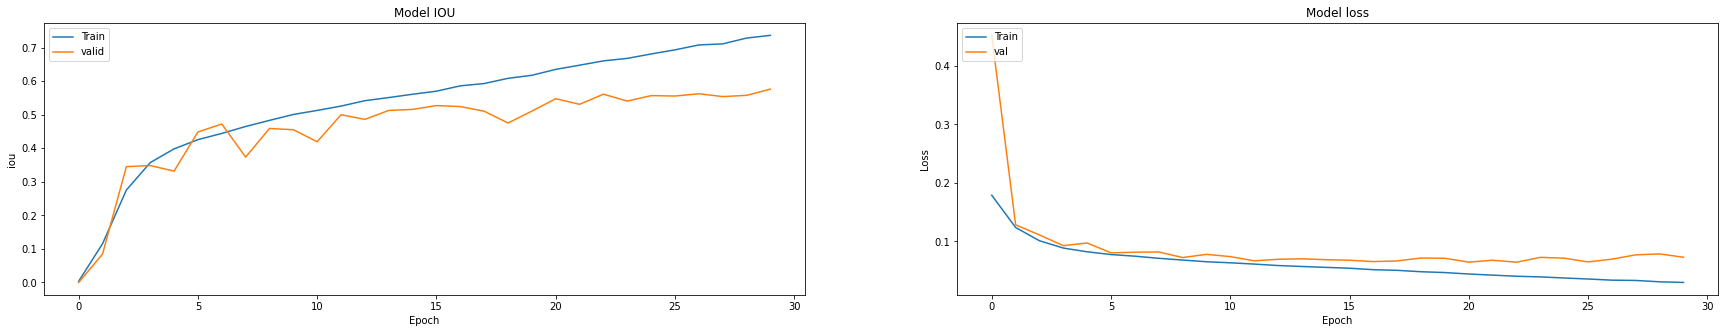

In [26]:
plot_performance()

### i.) Prediction on validation images

In [ ]:
def predict_valid(model,n):

  # paths of images
  sat_images_path_list = valid_df['sat_image_path'][0:n].to_list()

  # paths of masked images
  mask_images_path_list = valid_df['mask_path'][0:n].to_list()

  for sat_img_path, mask_img_path in zip(sat_images_path_list, mask_images_path_list):

      # original image
      sat_img = plt.imread(sat_img_path)

      # mask image
      mask_img = plt.imread(mask_img_path)
      mask_img = mask_img[:,:,0]

      # prediction
      predict_proba  = model.predict(sat_img[np.newaxis,:,:,:])
      predict_proba = predict_proba.reshape(sat_img.shape[0], sat_img.shape[1])

      # automatic threshold identification
      th = threshold_otsu(predict_proba)

      # binarizing the mask
      _, predict_mask = cv.threshold(src=predict_proba, thresh=th, maxval=255, type=cv.THRESH_BINARY)
      
      # titles
      sat_title = sat_img_path.split('/')[1]
      mask_title = mask_img_path.split('/')[1]
      
      # plotting figure
      plt.figure(figsize=(10, 10))
      
      plt.subplot(1,3,1)
      plt.title(sat_title)
      plt.imshow(sat_img, cmap='gray')

      plt.subplot(1,3,2)
      plt.title(mask_title)
      plt.imshow(mask_img, cmap='gray')

      plt.subplot(1,3,3)
      plt.title("Prediction")
      plt.imshow(predict_mask, cmap='gray')
      
      plt.show()
  
  return None

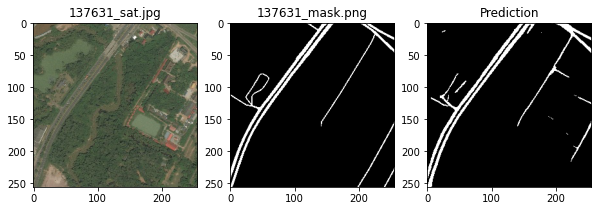

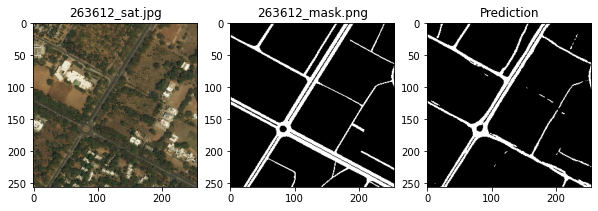

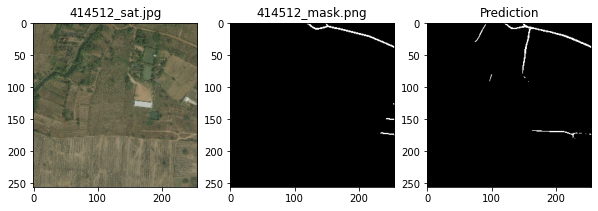

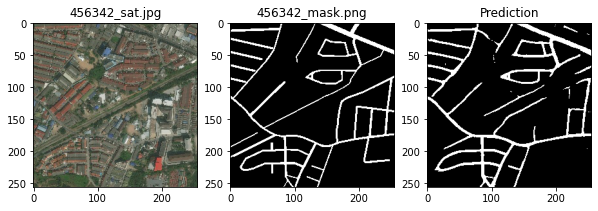

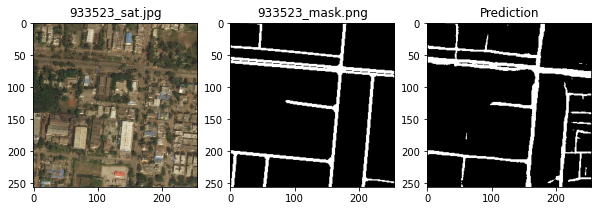

In [ ]:
predict_valid(model,n=5)

### ii.) Prediction on test images

In [ ]:
def predict_test(model,n):
  
  test_df = df[df['split'] == 'test']

  # paths of images
  sat_images_path_list = test_df['sat_image_path'][0:n].to_list()

  for sat_img_path in sat_images_path_list:

      # original image
      sat_img = plt.imread(sat_img_path)

      # prediction
      predict_proba  = model.predict(sat_img[np.newaxis,:,:,:])
      predict_proba = predict_proba.reshape(sat_img.shape[0], sat_img.shape[1])

      # automatic threshold identification
      th = threshold_otsu(predict_proba)
      print(th)

      # binarizing the mask
      _, predict_mask = cv.threshold(src=predict_proba, thresh=th, maxval=255, type=cv.THRESH_BINARY)
      
      # titles
      sat_title = sat_img_path.split('/')[1]
      
      # plotting figure
      plt.figure(figsize=(10, 10))
      
      plt.subplot(1,2,1)
      plt.title(sat_title)
      plt.imshow(sat_img, cmap='gray')

      plt.subplot(1,2,2)
      plt.title("Prediction")
      plt.imshow(predict_mask, cmap='gray')
      
      plt.show()
  
  return None

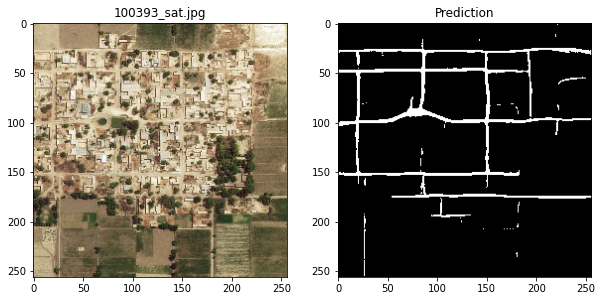

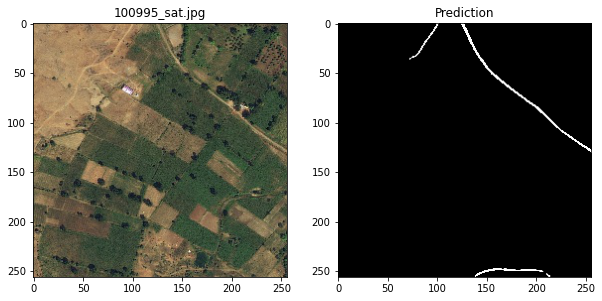

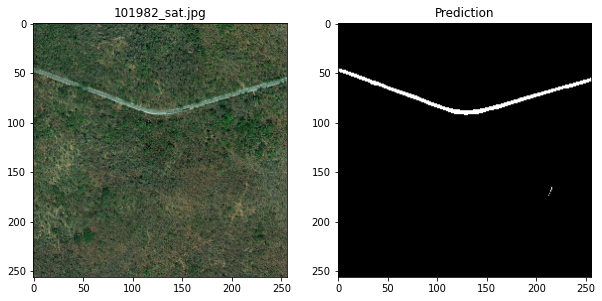

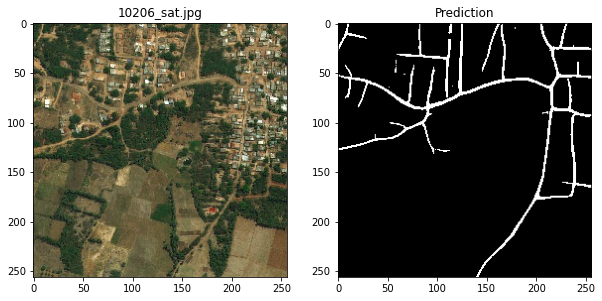

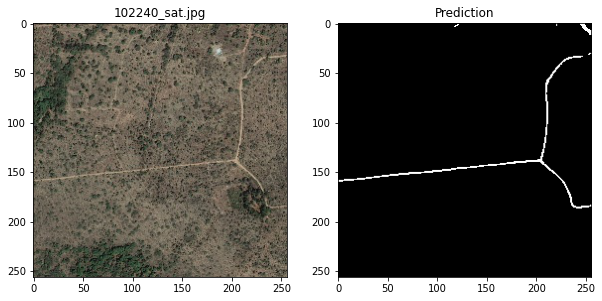

In [ ]:
predict_test(model,n=5)

### 2.3.2 Augmentation

In [ ]:
train_dataset = Dataset(train_df, Augment=True)
valid_dataset = Dataset(valid_df, Augment=True)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=True)

print(train_dataloader[0][0].shape)
print(valid_dataloader[0][1].shape)

model.compile(optimizer = Adam(0.001), loss='binary_crossentropy', metrics=[iou])            

(32, 256, 256, 3)
(32, 256, 256)


In [ ]:
# define callbacks for learning rate scheduling and best checkpoints saving
filepath = '/content/drive/MyDrive/Colab_Notebooks/DeepGlobeRoadExtraction/weights/U_Net_augment/weights-{epoch:02d}-{val_iou:.3f}.h5'

callbacks = [ModelCheckpoint(filepath=filepath, save_weights_only=True, save_best_only=True,mode='max', monitor='val_iou',verbose=1),
             EarlyStopping(monitor='val_iou',min_delta=0.001,patience=5,mode='max',verbose=1)]

In [ ]:
history = model.fit(x=train_dataloader,steps_per_epoch=len(train_dataloader),epochs=35,validation_data=valid_dataloader,callbacks=callbacks)

Epoch 1/35
155/155 [==============================] - ETA: 0s - loss: 0.1589 - iou: 0.0044
Epoch 1: val_iou improved from -inf to 0.02134, saving model to /content/drive/MyDrive/Colab_Notebooks/DeepGlobeRoadExtraction/weights/U_Net_augment/weights-01-0.021.h5
155/155 [==============================] - 302s 2s/step - loss: 0.1589 - iou: 0.0044 - val_loss: 0.2485 - val_iou: 0.0213
Epoch 2/35
155/155 [==============================] - ETA: 0s - loss: 0.1234 - iou: 0.1153
Epoch 2: val_iou improved from 0.02134 to 0.09471, saving model to /content/drive/MyDrive/Colab_Notebooks/DeepGlobeRoadExtraction/weights/U_Net_augment/weights-02-0.095.h5
155/155 [==============================] - 300s 2s/step - loss: 0.1234 - iou: 0.1153 - val_loss: 0.1319 - val_iou: 0.0947
Epoch 3/35
155/155 [==============================] - ETA: 0s - loss: 0.1063 - iou: 0.2394
Epoch 3: val_iou improved from 0.09471 to 0.28868, saving model to /content/drive/MyDrive/Colab_Notebooks/DeepGlobeRoadExtraction/weights/U_Ne

In [ ]:
model.load_weights('/content/drive/MyDrive/Colab_Notebooks/DeepGlobeRoadExtraction/weights/U_Net_augment/weights-21-0.539.h5')

In [ ]:
history = model.fit(x=train_dataloader,steps_per_epoch=len(train_dataloader),epochs=10,validation_data=valid_dataloader,callbacks=callbacks)

Epoch 1/10
155/155 [==============================] - ETA: 0s - loss: 0.0579 - iou: 0.5471
Epoch 1: val_iou improved from -inf to 0.48558, saving model to /content/drive/MyDrive/Colab_Notebooks/DeepGlobeRoadExtraction/weights/U_Net_augment/weights-01-0.486.h5
155/155 [==============================] - 306s 2s/step - loss: 0.0579 - iou: 0.5471 - val_loss: 0.0680 - val_iou: 0.4856
Epoch 2/10
155/155 [==============================] - ETA: 0s - loss: 0.0570 - iou: 0.5525
Epoch 2: val_iou did not improve from 0.48558
155/155 [==============================] - 302s 2s/step - loss: 0.0570 - iou: 0.5525 - val_loss: 0.0728 - val_iou: 0.4800
Epoch 3/10
155/155 [==============================] - ETA: 0s - loss: 0.0563 - iou: 0.5582
Epoch 3: val_iou improved from 0.48558 to 0.50776, saving model to /content/drive/MyDrive/Colab_Notebooks/DeepGlobeRoadExtraction/weights/U_Net_augment/weights-03-0.508.h5
155/155 [==============================] - 302s 2s/step - loss: 0.0563 - iou: 0.5582 - val_loss:

In [ ]:
model.load_weights('/content/drive/MyDrive/Colab_Notebooks/DeepGlobeRoadExtraction/weights/U_Net_augment/weights-08-0.555.h5')

In [ ]:
history = model.fit(x=train_dataloader,steps_per_epoch=len(train_dataloader),epochs=10,validation_data=valid_dataloader,callbacks=callbacks)

Epoch 1/10
155/155 [==============================] - ETA: 0s - loss: 0.0521 - iou: 0.5837
Epoch 1: val_iou did not improve from 0.55547
155/155 [==============================] - 303s 2s/step - loss: 0.0521 - iou: 0.5837 - val_loss: 0.0678 - val_iou: 0.5256
Epoch 2/10
155/155 [==============================] - ETA: 0s - loss: 0.0514 - iou: 0.5881
Epoch 2: val_iou did not improve from 0.55547
155/155 [==============================] - 302s 2s/step - loss: 0.0514 - iou: 0.5881 - val_loss: 0.0638 - val_iou: 0.5298
Epoch 3/10
155/155 [==============================] - ETA: 0s - loss: 0.0506 - iou: 0.5935
Epoch 3: val_iou did not improve from 0.55547
155/155 [==============================] - 302s 2s/step - loss: 0.0506 - iou: 0.5935 - val_loss: 0.0629 - val_iou: 0.5271
Epoch 4/10
155/155 [==============================] - ETA: 0s - loss: 0.0500 - iou: 0.5970
Epoch 4: val_iou did not improve from 0.55547
155/155 [==============================] - 302s 2s/step - loss: 0.0500 - iou: 0.5970 -

In [65]:
model.load_weights('/content/drive/MyDrive/Colab_Notebooks/DeepGlobeRoadExtraction/weights/U_Net_augment/weights-06-0.568.h5')

In [37]:
iou_augment = [0.0044,0.1153,0.2394,0.2981,0.3669,0.3967,0.4215,0.4389,0.4531,0.4676,0.4792,0.4886,0.4979,0.5067,0.5068,0.5192,0.5228,0.5298,0.5358,0.5378,0.5433,0.5471,0.5525,0.5582,0.5628,0.5622,0.5719,0.5759,0.5798,0.5837,0.5881,0.5935,0.5970,0.5992,0.6020]
val_iou_augment = [0.0213,0.0947,0.2887,0.3601,0.2933,0.3581,0.3502,0.3869,0.4583,0.4563,0.4712,0.4307,0.5077,0.4439,0.5063,0.4917,0.4921,0.5101,0.4789,0.4927,0.5387,0.4856,0.4800,0.5078,0.3853,0.5371,0.5522,0.5337,0.5555,0.5256,0.5298,0.5271,0.5210,0.5338,0.5677]

In [42]:
loss_augment = [0.1589,0.1234,0.1063,0.0967,0.0870,0.0821,0.0782,0.0754,0.0732,0.0708,0.0688,0.0673,0.0658,0.0644,0.0642,0.0623,0.0617,0.0606,0.0597,0.0594,0.0584,0.0579,0.0570,0.0563,0.0554,0.0554,0.0540,0.0533,0.0528,0.0521,0.0514,0.0506,0.0500,0.0498,0.0493]
val_loss_augment = [0.2485,0.1319,0.1568,0.1101,0.1006,0.0868,0.0866,0.0886,0.0821,0.0747,0.0722,0.0771,0.0714,0.0734,0.0679,0.0675,0.0664,0.0667,0.0669,0.0712,0.0644,0.0680,0.0728,0.0637,0.0965,0.0634,0.0609,0.0672,0.0653,0.0678,0.0638,0.0629,0.0672,0.0686,0.0593]

In [43]:
# Plot training & validation iou_score values
def plot_performance_augment():
  plt.figure(figsize=(30, 5))
  plt.subplot(121)
  plt.plot(iou_augment)
  plt.plot(val_iou_augment)
  plt.title('Model IOU')
  plt.ylabel('iou')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'valid'], loc='upper left')

  # Plot training & validation loss values
  plt.subplot(122)
  plt.plot(loss_augment)
  plt.plot(val_loss_augment)
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'val'], loc='upper left')
  plt.show()
  return None

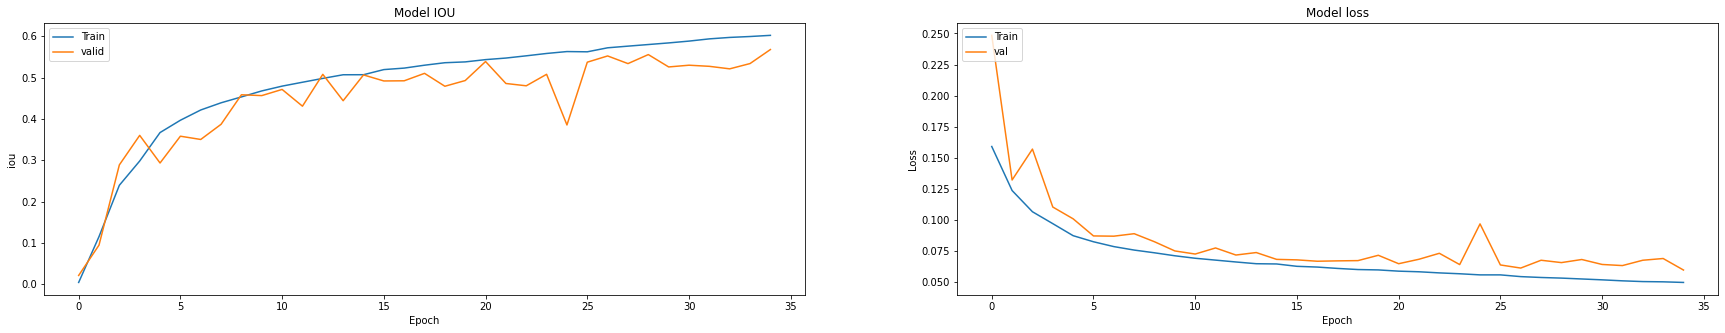

In [44]:
plot_performance_augment()

### i.) Prediction on validation images

In [ ]:
def predict_valid_augment(model,n):

  # paths of images
  sat_images_path_list = valid_df['sat_image_path'][0:n].to_list()

  # paths of masked images
  mask_images_path_list = valid_df['mask_path'][0:n].to_list()

  for sat_img_path, mask_img_path in zip(sat_images_path_list, mask_images_path_list):

      # original image
      sat_img = plt.imread(sat_img_path)

      # mask image
      mask_img = plt.imread(mask_img_path)
      mask_img = mask_img[:,:,0]

      # prediction
      predict_proba  = model.predict(sat_img[np.newaxis,:,:,:])
      predict_proba = predict_proba.reshape(sat_img.shape[0], sat_img.shape[1])

      # automatic threshold identification
      th = threshold_otsu(predict_proba)

      # binarizing the mask
      _, predict_mask = cv.threshold(src=predict_proba, thresh=th, maxval=255, type=cv.THRESH_BINARY)
      
      # titles
      sat_title = sat_img_path.split('/')[1]
      mask_title = mask_img_path.split('/')[1]
      
      # plotting figure
      plt.figure(figsize=(10, 10))
      
      plt.subplot(1,3,1)
      plt.title(sat_title)
      plt.imshow(sat_img, cmap='gray')

      plt.subplot(1,3,2)
      plt.title(mask_title)
      plt.imshow(mask_img, cmap='gray')

      plt.subplot(1,3,3)
      plt.title("Prediction")
      plt.imshow(predict_mask, cmap='gray')
      
      plt.show()
  
  return None

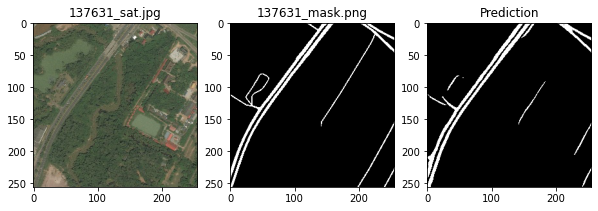

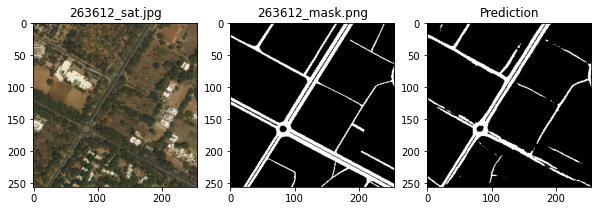

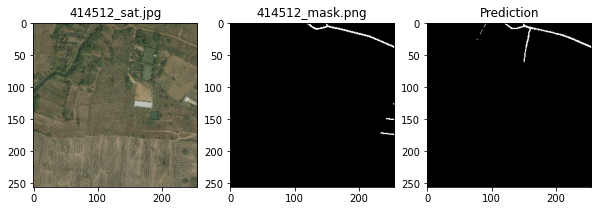

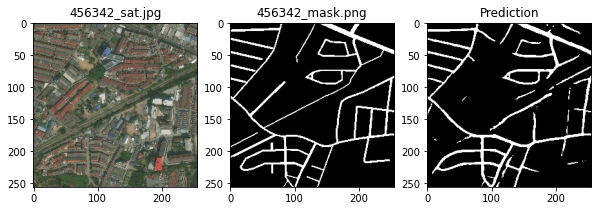

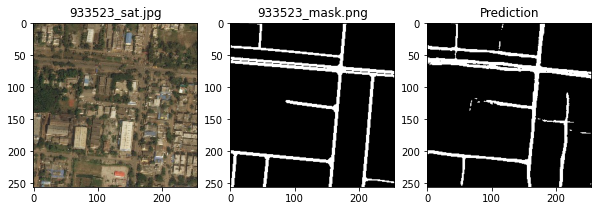

In [ ]:
predict_valid_augment(model,n=5)

### ii.) Prediction on test images

In [ ]:
def predict_test_augment(model,n):
  
  test_df = df[df['split'] == 'test']

  # paths of images
  sat_images_path_list = test_df['sat_image_path'][0:n].to_list()

  for sat_img_path in sat_images_path_list:

      # original image
      sat_img = plt.imread(sat_img_path)

      # prediction
      predict_proba  = model.predict(sat_img[np.newaxis,:,:,:])
      predict_proba = predict_proba.reshape(sat_img.shape[0], sat_img.shape[1])

      # automatic threshold identification
      th = threshold_otsu(predict_proba)

      # binarizing the mask
      _, predict_mask = cv.threshold(src=predict_proba, thresh=th, maxval=255, type=cv.THRESH_BINARY)
      
      # titles
      sat_title = sat_img_path.split('/')[1]
      
      # plotting figure
      plt.figure(figsize=(10, 10))
      
      plt.subplot(1,2,1)
      plt.title(sat_title)
      plt.imshow(sat_img, cmap='gray')

      plt.subplot(1,2,2)
      plt.title("Prediction")
      plt.imshow(predict_mask, cmap='gray')
      
      plt.show()
  
  return None

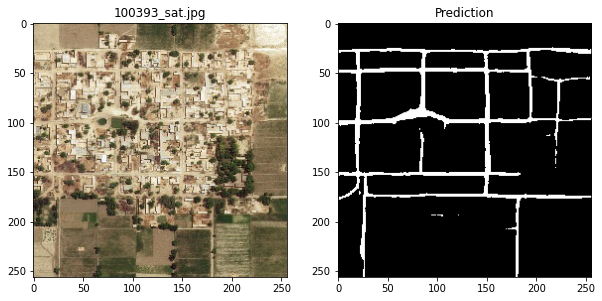

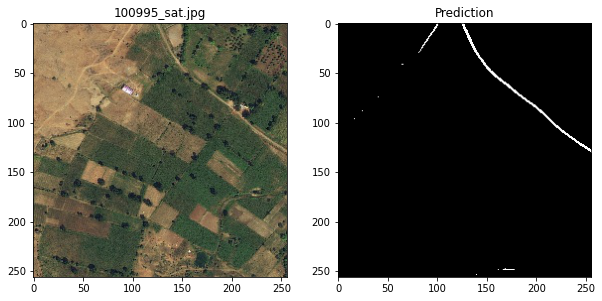

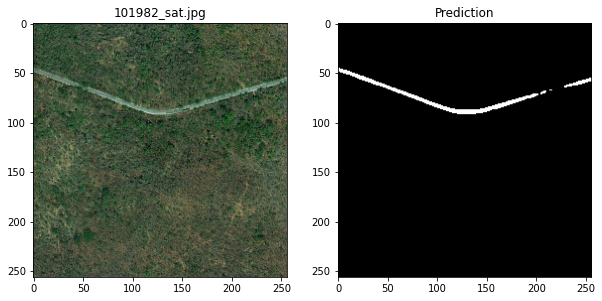

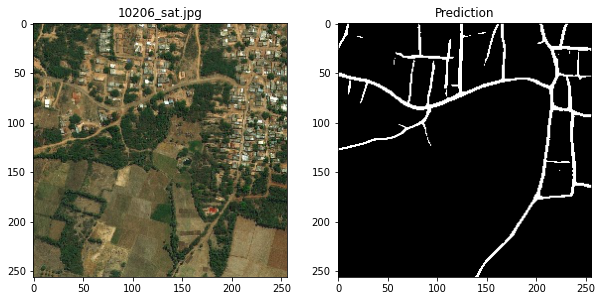

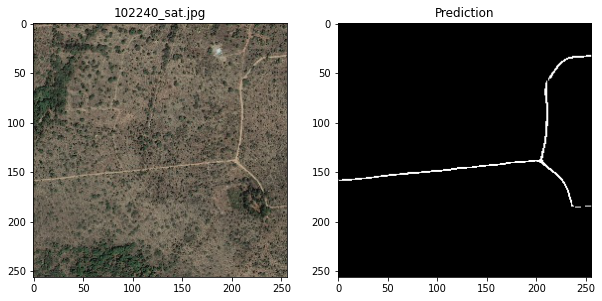

In [46]:
predict_test_augment(model,n=5)

## 3. Augmentation vs No Augmentation

In [62]:
def plot_augment_vs_noAugment():

  plt.figure(figsize=(20, 10))
  plt.subplot(221)
  plt.plot(iou_no_augment)
  plt.plot(val_iou_no_augment)
  plt.title('No Augmentation - IOU')
  plt.ylabel('iou')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'valid'], loc='upper left')

  plt.subplot(222)
  plt.plot(iou_augment)
  plt.plot(val_iou_augment)
  plt.title('Augmentation - IOU')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'val'], loc='upper left')
  
  plt.subplot(223)
  plt.plot(loss_no_augment)
  plt.plot(val_loss_no_augment)
  plt.title('No Augmentation - loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'val'], loc='upper left')
  
  plt.subplot(224)
  plt.plot(loss_augment)
  plt.plot(val_loss_augment)
  plt.title('Augmentation - loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'val'], loc='upper left')

  plt.show()
  return None

#### Plots for IOU and loss

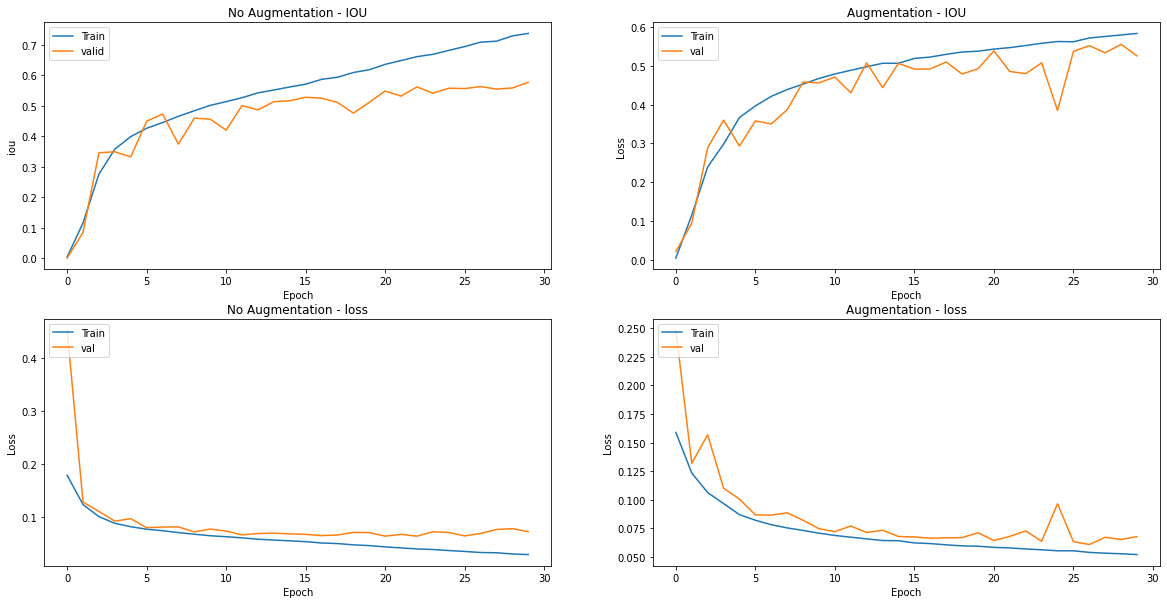

In [63]:
plot_augment_vs_noAugment()

### observations

*  In the above plot we have IOU and loss plots for both with and without augmentation. So, itseems like model is very slightly overfitted without augmentation.
* Performance of model without augmentation is slightly higher compared to model with augmentation where the model with augmentation it is converging at slighltly higher IOU score. 

*   Loss plot for both with and without augmentation is almost same
* So, Both techniques performances are almost at same level 





## 4. OpenCV vs Deeplearning results

In [72]:
def plot_opencv_vs_deep_learning():

  arr_sat = ['train/107770_sat.jpg','train/106797_sat.jpg','train/10466_sat.jpg','train/111121_sat.jpg']
  arr_mask = ['train/107770_mask.png','train/106797_mask.png','train/10466_mask.png','train/111121_mask.png']

  for i in range(len(arr_sat)):

    #read normal satellite image
    img_sat = plt.imread(arr_sat[i])
    
    #read mask image
    img_mask = plt.imread(arr_mask[i])
    
    #compute canny edges using satellite image
    gray_img = cv.cvtColor(img_sat, cv.COLOR_BGR2GRAY)
    blur_img = cv.GaussianBlur(gray_img, (3,3), 0)
    img_canny = cv.Canny(image=blur_img, threshold1=150, threshold2=255)

    # prediction
    predict_proba  = model.predict(img_sat[np.newaxis,:,:,:])
    predict_proba = predict_proba.reshape(img_sat.shape[0], img_sat.shape[1])

    # automatic threshold identification
    th = threshold_otsu(predict_proba)

    # binarizing the mask
    _, predict_mask = cv.threshold(src=predict_proba, thresh=th, maxval=255, type=cv.THRESH_BINARY)
    
    # titles
    sat_title = arr_sat[i].split('/')[1]
    mask_title = arr_mask[i].split('/')[1]
    
    # plotting figure
    plt.figure(figsize=(10, 10))
    
    plt.subplot(1,4,1)
    plt.title(sat_title)
    plt.axis('off')
    plt.imshow(img_sat, cmap='gray')

    plt.subplot(1,4,2)
    plt.title(mask_title)
    plt.axis('off')
    plt.imshow(img_mask, cmap='gray')

    plt.subplot(1,4,3)
    plt.title("OpenCV prediction")
    plt.axis('off')
    plt.imshow(img_canny, cmap='gray')

    plt.subplot(1,4,4)
    plt.title("DeepLearning prediction")
    plt.axis('off')
    plt.imshow(predict_mask, cmap='gray')
    
    plt.show()


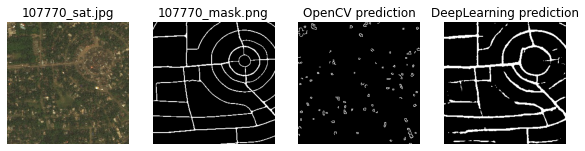

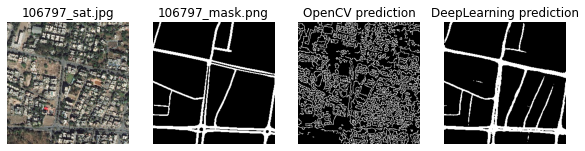

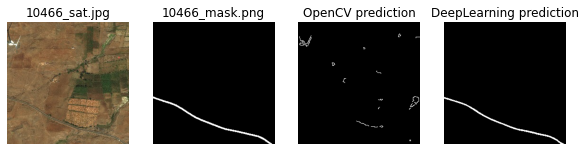

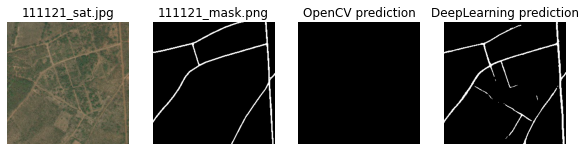

In [73]:
plot_opencv_vs_deep_learning()

## 5. Conclusions

*   OpenCV canny edge filter technique is used to extract the road it worked in few cases but failed in other complex road path images
*   Custom U-Net architecture is created and traing the model with and without augmentation.

*   Model is trained with and without augmentation for 30-35 epochs and after that iou scores and loss are converging
*   From above plots the performance of models trained with and without augmentation are almost at same level but there is very little higher iou score and better plots for model which trained without augmentation.
* So, Next we shall use segmentation models and use transfer learning technique by using backbones as state of the art machine learning models like Resnet34,VGG16,InceptionV3 etc..



